In [23]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, auc

from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import warnings
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

In [24]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)
        
        
def prepare_predictor(data_sets, data_path):
    """
    Args:
        data_sets list(str): names of datasets
    """
        
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    X_all      = []
    length_all = []
    
    for file in data_sets:
        #data = xr.open_dataset(os.path.join(data_path, f"{file}.nc"))
        data= pd.read_csv(f'{file}.csv')
        X_all.append(data)
        #length_all.append(Series(X_all).size)
    
    #X = xr.concat(X_all,dim='time')
    X= pd.concat(X_all, sort=False)
    #length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    
    #if time_reindex:
        #X = X.assign_coords(time=np.arange(len(X.time)))

    return X
#, length_all

def prepare_predictand(data_sets,data_path):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    Y_all = []
    length_all = []
    
    for file in data_sets:
        data= pd.read_csv(f'{file}.csv')
        Y_all.append(data)
    
    length_all = np.array(length_all)
    Y= pd.concat(Y_all, sort=False)
    
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    
    
    
    
# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):
    
    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)
    
    return yr, mean

In [28]:
# Training set
train_files = ["newtrain_x"]
train_path = '/Users/huangyining/Desktop/'
X_train_xr  = prepare_predictor(train_files,train_path)
train_files = ["newtrain_y"]
y_train_xr  = prepare_predictand(train_files,train_path)

# Test set
test_path = '/Users/huangyining/Desktop/'
train_files=['newtest_x']
X_test_xr = prepare_predictor(train_files, data_path=test_path)
train_files=['newtest_y']
y_test_xr = prepare_predictand(train_files,data_path=test_path)

In [29]:
X_train_xr=X_train_xr.drop(columns=['HourlyDryBulbTemperature_x'])
X_test_xr=X_test_xr.drop(columns=['HourlyDryBulbTemperature_x'])

In [46]:
X_train_df = pd.DataFrame({"housingunits": X_train_xr["Housing Units"],
                           "population": X_train_xr["Total Population"],
                           "radiation" :X_train_xr["raidation"],
                           "windpeed": X_train_xr["HourlyWindpeed_x"],
                           "humidity" :X_train_xr["HourlyRelativeHumidity"],
                           "pressure": X_train_xr["HourlySeaLevelPressure"],
                           "LU": X_train_xr["LU"],
                           "Dew": X_train_xr["HourlyDewPointTemperature_x"],})
                           #"LST": X_train_xr["HourlyDryBulbTemperature_y"]

X_test_df  = pd.DataFrame({"housingunits": X_test_xr["Housing Units"],
                           "population": X_test_xr["Total Population"],
                           "radiation" :X_test_xr["raidation"],
                           "windpeed": X_test_xr["HourlyWindpeed_x"],
                           "humidity" :X_test_xr["HourlyRelativeHumidity"],
                           "pressure": X_test_xr["HourlySeaLevelPressure"],
                           "LU": X_test_xr["LU"],
                           "Dew": X_test_xr["HourlyDewPointTemperature_x"]})
                           #"LST": X_test_xr["HourlyDryBulbTemperature_y"]
                          

y_train_df =pd.DataFrame({
                          "LST": y_train_xr["delta"]
                          })
y_test_df =pd.DataFrame({
                          "LST": y_test_xr["delta"]
                          })

In [47]:
#Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std
X_train_df.dropna()
y_train_df.dropna()
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)


,housingunits,population,radiation,windpeed,humidity,pressure,LU,Dew
0,-1.326401,-0.339664,-1.405915,1.012813,-0.813905,1.391209,-1.192559,-1.766105
1,-1.326401,-0.339664,-0.372659,1.012813,-0.651552,1.651556,-1.192559,-1.466558
2,-1.326401,-0.339664,0.660597,-1.452949,-0.651552,1.347818,-1.192559,-1.266860
3,-1.326401,-0.339664,1.177225,-0.083081,-0.272728,1.304427,-1.192559,-1.216936
4,-1.326401,-0.339664,-1.405915,2.930629,1.080213,0.610169,-1.192559,-0.917389
...,...,...,...,...,...,...,...,...
6343,1.579529,-1.865476,-0.372659,-0.631029,1.404919,-1.342432,0.212746,1.478984
6344,1.579529,-1.865476,1.177225,-1.452949,1.513155,-1.906516,0.212746,1.379135
6345,1.579529,-1.865476,-1.405915,1.012813,1.350802,-2.427210,0.212746,0.979740
6346,1.579529,-1.865476,-0.372659,2.108708,-0.164493,-1.776343,0.212746,0.081100


,LST
0,7
1,4
2,2
3,5
4,10
...,...
6343,2
6344,1
6345,2
6346,2


(6348, 8) (589, 8)


In [48]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Importing metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [49]:
gb = GradientBoostingRegressor()

crs = cross_val_score(gb, X_train, y_train, cv=5, scoring='r2')
print('Average R2:', crs.mean())


/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A 

Average R2: 0.3049581169953162


In [50]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

In [51]:
learning_rate     = 0.01
n_estimators      = 60     # Number of trees in random forest
min_child_weight  = 1      # Minimum number of samples required to split a node
gamma             = 0.1      # Minimum number of samples required at each leaf node
subsample         = 0.5 # Number of features to consider at every split
max_depth         = 55     # Maximum number of levels in tree
colsample_bytree  = 0.5   # Method of selecting samples for training each tree
reg_alpha         = 1 
reg_lambda        = 1
seed              =12

reg0 = xgb.XGBRegressor(n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    min_child_weight=min_child_weight,
                    gamma=gamma,
                    subsample=subsample,
                    max_depth=max_depth,
                    colsample_bytree=colsample_bytree,
                    reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda,
                    seed =seed)


In [52]:
model = reg0.fit(X_train, y_train)

In [53]:
y_test_pre = model.predict(X_test)

In [54]:
# Number of trees in XGBoost
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 120, num = 60)]
learning_rate = [x for x in np.linspace(start = 0.01, stop = 0.1, num = 60)]
min_child_weight = [int(x) for x in np.linspace(start = 1, stop = 10)]
gamma = [x for x in np.linspace(start = 0.1, stop = 0.5)]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 8)]
max_depth.append(None)
subsample = [x for x in np.linspace(start = 0.5, stop = 0.8)]
colsample_bytree = [x for x in np.linspace(start = 0.5, stop = 0.8)]
reg_alpha = [x for x in np.linspace(start = 1, stop = 5)]
reg_lambda = [x for x in np.linspace(start = 1, stop = 5)]
seed = [12]
random_grid = {'n_estimators':n_estimators,
                    'learning_rate':learning_rate,
                    'min_child_weight':min_child_weight,
                    'gamma':gamma,
                    'subsample':subsample,
                    'max_depth':max_depth,
                    'colsample_bytree':colsample_bytree,
                    'reg_alpha':reg_alpha,
                    'reg_lambda':reg_lambda,
                    'seed':seed}


In [55]:
print(random_grid)

{'n_estimators': [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120], 'learning_rate': [0.01, 0.01152542372881356, 0.01305084745762712, 0.014576271186440679, 0.01610169491525424, 0.017627118644067796, 0.01915254237288136, 0.020677966101694915, 0.02220338983050848, 0.023728813559322035, 0.025254237288135598, 0.026779661016949154, 0.028305084745762717, 0.029830508474576273, 0.031355932203389836, 0.03288135593220339, 0.034406779661016955, 0.03593220338983051, 0.037457627118644074, 0.03898305084745763, 0.04050847457627119, 0.042033898305084756, 0.04355932203389831, 0.04508474576271187, 0.04661016949152543, 0.048135593220338994, 0.04966101694915255, 0.05118644067796611, 0.05271186440677967, 0.05423728813559323, 0.05576271186440679, 0.057288135593220345, 0.05881355932203391, 0.060338983

In [56]:
reg0 = xgb.XGBRegressor(random_state=0)
# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_tas = rf_random0.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_tas.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/huangyining/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64In

The best hyperparameters: 
 {'subsample': 0.5857142857142857, 'seed': 12, 'reg_lambda': 3.8571428571428568, 'reg_alpha': 2.4693877551020407, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.034406779661016955, 'gamma': 0.3285714285714286, 'colsample_bytree': 0.7510204081632653}


In [57]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
reg0 = xgb.XGBRegressor(n_estimators=100,
                    learning_rate=0.034406779661016955,
                    min_child_weight=1,
                    gamma=0.3285714285714286,
                    subsample=0.5857142857142857,
                    max_depth=3,
                    colsample_bytree=0.7510204081632653,
                    reg_alpha=2.4693877551020407,
                    reg_lambda=3.8571428571428568,
                    seed =12)
model = reg0.fit(X_train, y_train)
y_test_pre = model.predict(X_test)

In [63]:
Ypre=pd.DataFrame(y_test_pre)
Ypre

,0
0,6.152467
1,2.499611
2,2.338624
3,5.368207
4,9.840546
...,...
584,2.885015
585,5.028813
586,0.845812
587,0.691797


In [64]:
importance=reg0.feature_importances_
indice=np.argsort(importance)[::1]
feat_labels=X_train_df.columns[0:]
for i in range(X_train.shape[1]):
    print(feat_labels[i],importance[indice[i]])

housingunits 0.053140994
population 0.05946906
radiation 0.061694797
windpeed 0.06944038
humidity 0.09722873
pressure 0.097730145
LU 0.17175438
Dew 0.38954157


Text(0.5, 0, 'True Difference')

Text(0, 0.5, 'Predicted Difference')

Text(0.5, 1.0, 'XGBoost Prediction Performance')

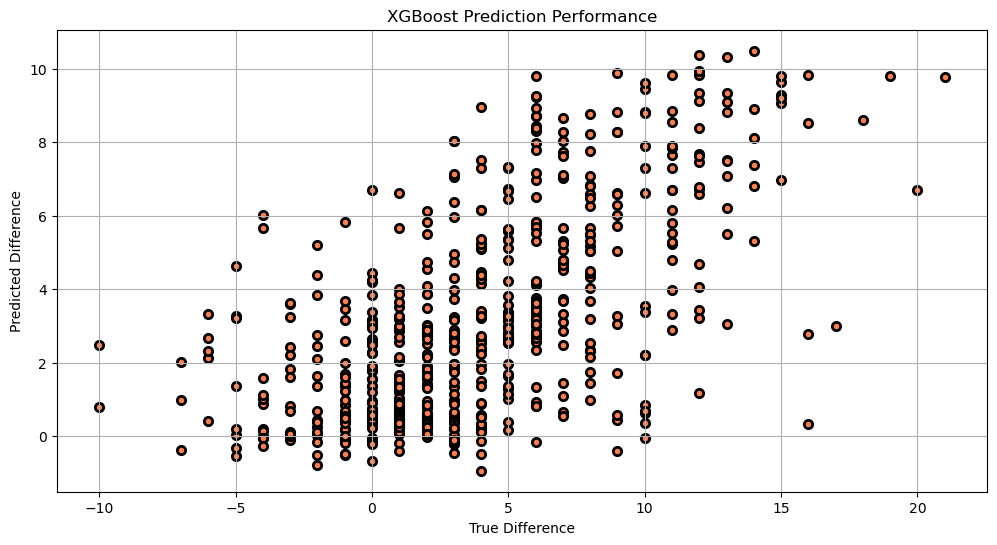

[CV] END colsample_bytree=0.7387755102040816, gamma=0.14081632653061227, learning_rate=0.04966101694915255, max_depth=5, min_child_weight=5, n_estimators=117, reg_alpha=1.816326530612245, reg_lambda=4.346938775510203, seed=12, subsample=0.6346938775510205; total time=   2.4s
[CV] END colsample_bytree=0.7387755102040816, gamma=0.14081632653061227, learning_rate=0.04966101694915255, max_depth=5, min_child_weight=5, n_estimators=117, reg_alpha=1.816326530612245, reg_lambda=4.346938775510203, seed=12, subsample=0.6346938775510205; total time=   2.4s
[CV] END colsample_bytree=0.7387755102040816, gamma=0.14081632653061227, learning_rate=0.04966101694915255, max_depth=5, min_child_weight=5, n_estimators=117, reg_alpha=1.816326530612245, reg_lambda=4.346938775510203, seed=12, subsample=0.6346938775510205; total time=   2.5s
[CV] END colsample_bytree=0.6836734693877551, gamma=0.2469387755102041, learning_rate=0.06949152542372881, max_depth=3, min_child_weight=9, n_estimators=94, reg_alpha=3.938

In [65]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(y_test_xr["delta"], y_test_pre,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('True Difference') 
plt.ylabel('Predicted Difference') 
plt.title('XGBoost Prediction Performance') 
plt.grid()